# Experimenting with an LLM residual stream 'data lane'

In [3]:
from transformers import AutoTokenizer, set_seed
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling


/bigdrive/anaconda3/envs/xf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Some setup

In [ ]:
set_seed(0)
out_dir = "./data-lane-output"
keep_dir = "./data-lane-output-keep"

## Custom config
Pull in the customized version of GPTNeoConfig

In [2]:
from datalane_model.configuration_datalane import DatalaneGPTNeoConfig

In [3]:
# CA: Mod 1 of 1 in notebook (three others in DataLaneGPTNeoForCausalLM.py)
#dl_config = DatalaneGPTNeoConfig() # Default (and baseline) hidden_size=768
dl_config = DatalaneGPTNeoConfig(hidden_size=768) # modify as necessary

In [4]:
dl_config

## Instantiate model with mods
See `datalane_model/modeling_datalane.py` for the mods

In [5]:
from datalane_model.modeling_datalane import DataLaneGPTNeoForCausalLM

In [6]:
model = DataLaneGPTNeoForCausalLM(dl_config)
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
tokenizer.pad_token = tokenizer.eos_token # This tokenizer doesn't have a pad_token, so setting one. Needed for training

Initializing custom model DataLaneGPTNeoModel
in DataLaneGPTNeoForCausalLM init, self.lm_head.in_features = 192, self.lm_head.out_features = 50257
Initializing custom model with head DataLaneGPTNeoForCausalLM


In [21]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params:,d} || all params: {all_param:,d} || trainable%: {trainable_params / all_param:.2%}"
    )

print_trainable_parameters(model)

trainable params: 39,566,016 || all params: 39,566,016 || trainable%: 100.00%


In [8]:
# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Move the model to the GPU
model = model.to(device)
print(f"{device = }")

device = device(type='cuda')


## Reinitialize the model if necessary

In [12]:
# This is only used when initially building the model

# def reinitialize_weights(model):
#     for _, module in model.named_modules(): 
#         if isinstance(module,(torch.nn.Linear, torch.nn.Embedding)):
#             module.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
#         elif isinstance(module, torch.nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
#         if isinstance(module, torch.nn.Linear) and module.bias is not None:
#             module.bias.data.zero_()
#     return model

# reinitialize_weights(model)

In [13]:
# If weights are newly initialized this should give garbage after the prompt

# prompt = "Once upon a time there was"
# input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
# output = model.generate(input_ids, max_length = 1000, num_beams=1, temperature=0.9) # Temp not affecting generation. Same every time
# output_text = tokenizer.decode(output[0], skip_special_tokens=True)
# print(output_text)

## Training
Note that our test set is only 1% of the total, but we're evaluating it about 25 times per epoch, so we're spending 1/4 of our training time doing eval! Doing eval half as often would be an easy and reasonable way to speed things up.

In [14]:
dataset = load_dataset("skeskinen/TinyStories-GPT4", split="train[:250000]") # Just the first 250k samples

tokenized_dataset = dataset.map(lambda examples: tokenizer(examples["story"], truncation=True, padding=True), batched=True)

# Split the dataset into train and test sets
train_test_split = tokenized_dataset.train_test_split(test_size=0.01, seed=42)

# Access the train and test sets
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

In [15]:
dataset

Dataset({
    features: ['story', 'summary', 'source', 'prompt', 'words', 'features'],
    num_rows: 250000
})

In [16]:
#tokenized_dataset = dataset.map(lambda examples: tokenizer(examples["story"], truncation=True, padding=True), batched=True)

# Name the project for WandB
%env WANDB_PROJECT=datalane_33M

training_args = TrainingArguments(
    output_dir=out_dir,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    evaluation_strategy="steps",
    logging_strategy="steps",
    save_steps=500,
    eval_steps=5000,
    logging_steps=500,
    save_total_limit=2,
)

env: WANDB_PROJECT=datalane_33M


In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
#    train_dataset=tokenized_dataset["train"],
#    train_dataset=tokenized_dataset, # if doing subset for testing
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False) #, mlm_probability=0.15)
)
trainer.train()

/bigdrive/anaconda3/envs/xf/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Currently logged in as: chrisarmstrong. Use `wandb login --relogin` to force relogin


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
5000,3.446600,3.437557
10000,3.016200,2.998178
15000,2.739700,2.759513
20000,2.581800,2.594901
25000,2.443600,2.460556
30000,2.345900,2.353881
35000,2.249800,2.269639
40000,2.162500,2.191979
45000,2.116400,2.125712
50000,2.066200,2.072476


TrainOutput(global_step=123750, training_loss=2.168235733309659, metrics={'train_runtime': 30351.0487, 'train_samples_per_second': 8.155, 'train_steps_per_second': 4.077, 'total_flos': 4.049221682219213e+16, 'train_loss': 2.168235733309659, 'epoch': 1.0})

## Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Read the CSV file that I'm using to store run data

df = pd.read_csv(keep_dir + '/' + 'ML Runs _ Results - DataLane Runs.csv')

In [5]:
df

,W&B Name,Label,base model,num_layers,hidden_size (residual stream),embedding size,Trainable params,eval loss @ 98% of 1 epoch of 250k,eval loss delta from baseline,Training time (hours),Training,Initialization,Embed / DL config,Total DS,Test split,Notes
0,no-dl-clean-run-4,NoDL-96-96-5.5M,GPTNeo,4,96,96,"5,467,680",2.507,-50.9%,4.4,from scratch,random,NaN,250k,0.01,Embedding is entire (small) residual stream
1,no-dl-clean-run-5,NoDL-384-384-27M,GPTNeo,4,384,384,"27,179,136",1.761,-6.0%,6.6,from scratch,random,NaN,250k,0.01,Compare to run 3 (DL vs normal xf with semi-co...
2,no-dl-clean-run-0,NoDL-768-768-69M,GPTNeo,4,768,768,"68,514,048",1.661,0.0%,15.0,from scratch,random,NaN,250k,0.01,Baseline - embedding is entire residual stream...
3,dl-clean-run-1,DL-768-384-49M,GPTNeo with DL,4,768,384,"49,215,360",1.722,-3.7%,9.3,from scratch,random,same,250k,0.01,Embedding is 1/2 of baseline residual stream
4,dl-clean-run-2,DL-768-192-40M,GPTNeo with DL,4,768,192,"39,566,016",1.741,-4.8%,8.7,from scratch,random,same,250k,0.01,Embedding is 1/4 of baseline residual stream
5,dl-clean-run-3,DL-768-96-35M,GPTNeo with DL,4,768,96,"34,741,344",1.813,-9.2%,8.0,from scratch,random,same,250k,0.01,Embedding is 1/8 of baseline residual stream
6,switch-dl-clean-run-6,SwDL-768-192-40M,GPTNeo with sw DL,4,768,192,"39,566,016",1.741,-4.8%,8.4,from scratch,random,switch,250k,0.01,Compare to run 2 (same vs switch) - does switc...


In [39]:
# Ensure that 'Training time (hours)', 'eval loss @ 98% of 1 epoch of 250k',
# and 'Trainable params' are numeric

df['Training time (hours)'] = pd.to_numeric(df['Training time (hours)'], errors='coerce')
df['eval loss @ 98% of 1 epoch of 250k'] = pd.to_numeric(df['eval loss @ 98% of 1 epoch of 250k'], errors='coerce')
df['Trainable params'] = pd.to_numeric(df['Trainable params'].str.replace(',', ''))

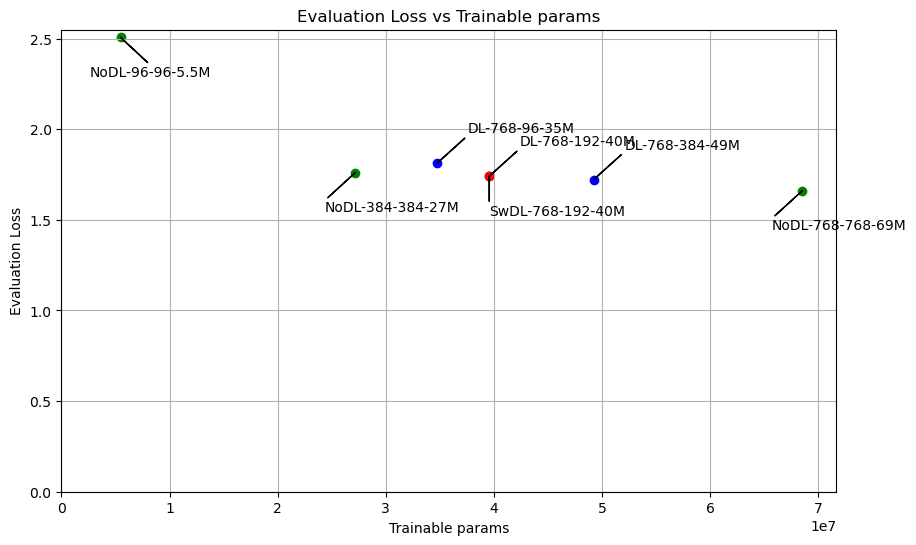

In [89]:
# Plot eval loss vs trainable params

plotlog = False
plt.figure(figsize=(10, 6))
ax = plt.gca() # Get the current Axes instance (for use with log scale)
if plotlog:
    ax.set_xscale('log') # Set the x-axis to a logarithmic scale

for i, txt in enumerate(df['Label']):
    if txt.startswith("DL"):
        color = 'blue'
        xytext=(22,22)
    elif txt.startswith("NoDL"):
        color = 'green'
        xytext=(-22,-28)
    elif txt.startswith("SwDL"):
        color = 'red'
        xytext=(0,-28)
    else:
        color = 'black'
        xytext=(22,22)
   
    plt.scatter(df['Trainable params'].iloc[i], df['eval loss @ 98% of 1 epoch of 250k'].iloc[i], color=color)
    plt.annotate(txt, (df['Trainable params'].iloc[i], df['eval loss @ 98% of 1 epoch of 250k'].iloc[i]), 
             xytext=xytext, textcoords='offset points',
             arrowprops=dict(facecolor='black', width=0.1, headlength=1.0, headwidth=0.0, shrink=0.))

plt.title('Evaluation Loss vs Trainable params')
plt.xlabel('Trainable params')
plt.ylabel('Evaluation Loss')
plt.grid(True)
ax.set_xlim([0, None])
ax.set_ylim([0, None])
plt.show()


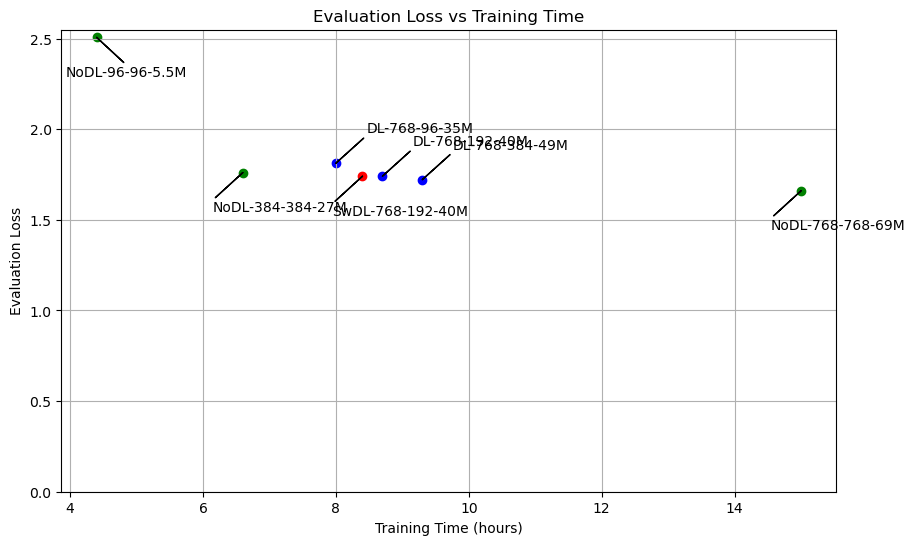

In [88]:
# Plot eval loss vs training time

plotlog = False
plt.figure(figsize=(10, 6))
ax = plt.gca() # Get the current Axes instance (for use with log scale)
if plotlog:
    ax.set_xscale('log') # Set the x-axis to a logarithmic scale

for i, txt in enumerate(df['Label']):
    if txt.startswith("DL"):
        color = 'blue'
        xytext=(22,22)
    elif txt.startswith("NoDL"):
        color = 'green'
        xytext=(-22,-28)
    elif txt.startswith("SwDL"):
        color = 'red'
        xytext=(-22,-28)
    else:
        color = 'black'
        xytext=(22,22)

    plt.scatter(df['Training time (hours)'].iloc[i], df['eval loss @ 98% of 1 epoch of 250k'].iloc[i], color=color)
    plt.annotate(txt, (df['Training time (hours)'].iloc[i], df['eval loss @ 98% of 1 epoch of 250k'].iloc[i]), 
             xytext=xytext, textcoords='offset points',
             arrowprops=dict(facecolor='black', width=0.1, headlength=1.0, headwidth=0.0, shrink=0.))

plt.title('Evaluation Loss vs Training Time')
plt.xlabel('Training Time (hours)')
plt.ylabel('Evaluation Loss')
plt.grid(True)
ax.set_ylim([0, None]) # Set the minimum value of the y-axis to 0
plt.show()

## Restore from checkpoint (if needed)
Note: requires restarting the kernel.

In [ ]:
set_seed(0)

from transformers import GPTNeoForCausalLM
model = GPTNeoForCausalLM.from_pretrained(keep_dir + "/" + "checkpoint-123500", device_map="auto")

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
tokenizer.pad_token = tokenizer.eos_token

device = model.device
print(device)

## Test LLM Generation

In [ ]:
prompt = "Once upon a time there was"
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
output = model.generate(input_ids, max_length = 1000, num_beams=1, do_sample=True, temperature=0.9) # do_sample=True gives non-greedy sampling
output_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(output_text)